# TBL Model Development: Random Forest Regression

In [18]:
# imports

import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from joblib import Parallel, delayed
from xgboost import XGBRFRegressor


In [19]:
# Processing Data Function (switching to using radius)

def read_and_process_data(directory_path):
    data_frames = []
    columns_to_extract = ['radius_X', 'radius_Y', 'radius_Z', 'radius_Ox', 'radius_Oy', 'radius_Oz', 'Fx', 'Fy', 'Fz', 'Tx', 'Ty', 'Tz']

    # Assuming each cycle has exactly 356 data points
    total_data_points = 356

    for file_name in os.listdir(directory_path):
        if file_name.endswith(".csv"):
            file_path = os.path.join(directory_path, file_name)
            participant = int(os.path.basename(file_path).split('_')[0])
            cycle_id = os.path.basename(file_path).split('_')[1].split('.')[0]  # Extract cycle_id
            intensity = cycle_id[:4]  # Extract the first four characters of cycle_id as intensity

            # Read data from CSV and select only the desired columns
            df = pd.read_csv(file_path, usecols=columns_to_extract)

            # Add participant ID, cycle_id, and participant_cycle_id as features
            df['Participant'] = participant
            df['Cycle_ID'] = cycle_id
            df['Participant_Cycle_ID'] = f"{participant}_{cycle_id}"

            # Add normalized_cycle_position
            df['Normalized_Cycle_Position'] = df.index / (total_data_points - 1)
            df['Intensity'] = intensity  # this is either "HIIT" or "MICT"

            data_frames.append(df)

    # Concatenate all data frames
    processed_data = pd.concat(data_frames, ignore_index=True)

    # Merge with participant weights
    weights_df = pd.read_csv("Participant Weights.csv")
    weights_df['Weight'] = weights_df['Weight'].astype(float)
    weights_df['Wingspan'] = weights_df['Wingspan'].astype(float)
    processed_data = pd.merge(processed_data, weights_df, left_on='Participant', right_on='Participant')

    return processed_data


In [20]:
 # Set up paths
data_directory = "Processed Data for ML"

# Read and process data
data = read_and_process_data(data_directory)


# # Shuffle the data based on 'Participant_Cycle_ID'
# data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# # Split the data into train and test (80/20 split)
# train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['Participant_Cycle_ID'])

# # Specify the output columns
# output_columns = ['Fx', 'Fy', 'Fz', 'Tx', 'Ty', 'Tz']

# # Create X (input) and y (output) for train/validation/test
# X_train = train_data.drop(output_columns, axis=1)  # Dropping the output columns to create input
# y_train = train_data[output_columns]  # Creating output, each column will be a separate y

# X_test = test_data.drop(output_columns, axis=1)  # Dropping the output columns to create input
# y_test = test_data[output_columns]  # Creating output, each column will be a separate y

# Shuffle the data based on 'Participant_Cycle_ID'
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Get unique participants
participants = data['Participant'].unique()

# Randomly select 16 participants for the train set and 4 participants for the test set
train_participants = np.random.choice(participants, size=16, replace=False)
test_participants = np.setdiff1d(participants, train_participants)

# Split the data into train and test based on the selected participants
train_data = data[data['Participant'].isin(train_participants)]
test_data = data[data['Participant'].isin(test_participants)]

# Specify the output columns
output_columns = ['Fx', 'Fy', 'Fz', 'Tx', 'Ty', 'Tz']

# Create X (input) and y (output) for train/validation/test
X_train = train_data.drop(output_columns, axis=1)  # Dropping the output columns to create input
y_train = train_data[output_columns]  # Creating output, each column will be a separate y

X_test = test_data.drop(output_columns, axis=1)  # Dropping the output columns to create input
y_test = test_data[output_columns]  # Creating output, each column will be a separate y

In [26]:
# train models

# Define numerical and categorical features
numeric_features = ['radius_X', 'radius_Y', 'radius_Z', 'radius_Ox', 'radius_Oy', 'radius_Oz', 'Normalized_Cycle_Position', 'Weight', 'Wingspan']
categorical_features = ['Intensity']

# Create transformers for numerical and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a preprocessor that applies transformers to specific columns 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Create a pipeline with the preprocessor and the regressor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRFRegressor())
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'regressor__n_estimators': [100, 200, 300, 400, 500],  # Number of trees in the forest
}

# Create a GridSearchCV object
# grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to your training data
# grid_search.fit(X_train, y_train['Fx'])

# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the GridSearchCV object to your training data in parallel
with Parallel(n_jobs=-1):
    grid_search.fit(X_train, y_train)

# Access the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# report model metrics

print("Best Parameters:", best_params)

# Get the mean cross-validated "accuracy" score of the best model
best_score = grid_search.best_score_

print("Mean Accuracy of Best Model (in Validation):", best_score)

Best Parameters: {'regressor__n_estimators': 500}
Mean Accuracy of Best Model (in Validation): -42.880363486004015


In [85]:
import matplotlib.pyplot as plt
import numpy as np

def calculate_mdpe_by_participant_cycle_ids(y_pred, y_test, X_test, output_column):
    """
    Calculate Median Percentage Error (MDPE) for each unique participant_cycle_id for a specific output column.
    
    Args:
    - y_pred (numpy array): Predicted values.
    - y_test (numpy array): True values.
    - X_test (DataFrame): DataFrame containing the test data including 'Participant_Cycle_ID'.
    - output_column (str): Name of the output column.
    
    Returns:
    - mdpe_scores (dict): Dictionary containing MDPE scores for each unique participant_cycle_id.
    """
    mdpe_scores = []
    
    # Get unique participant_cycle_ids
    unique_participant_cycle_ids = X_test['Participant_Cycle_ID'].unique()
    m = 0
    # Calculate MDPE for each unique participant_cycle_id
    for unique_id in unique_participant_cycle_ids:
        mask = X_test['Participant_Cycle_ID'] == unique_id
        y_pred_id = y_pred[output_column][mask]
        y_test_id = y_test[output_column][mask]
        
        # Exclude NaN values
        mask_valid = ~np.isnan(y_test_id)
        y_pred_id = y_pred_id[mask_valid]
        y_test_id = y_test_id[mask_valid]
        
        mdpe = np.median((y_pred_id - y_test_id) / y_test_id * 100)
        mdpe_scores.append(mdpe)
        out_col = ['Fx', 'Fy', 'Fz', 'Tx', 'Ty', 'Tz']
        if m == 0:
            # Create subplots for each feature
            fig, axs = plt.subplots(6, 1, figsize=(24, 24))

            # Create x values from 0 to the length of y_pred_id
            x_values = list(range(len(y_pred_id)))

            # Plot the prediction and ground truth for each feature
            for i in range(6):
                axs[i].scatter(x_values, y_pred[out_col[i]][mask], label='Prediction')
                axs[i].scatter(x_values, y_test[out_col[i]][mask], label='Ground Truth')
                axs[i].set_xlabel('radius_' + chr(88 + i))  # X, Y, Z, Ox, Oy, Oz
                axs[i].set_ylabel('Fx')
                axs[i].legend()

            # Show the plot
            plt.show()
        m += 1
        
    return mdpe_scores

(17088,)


TypeError: list indices must be integers or slices, not Series

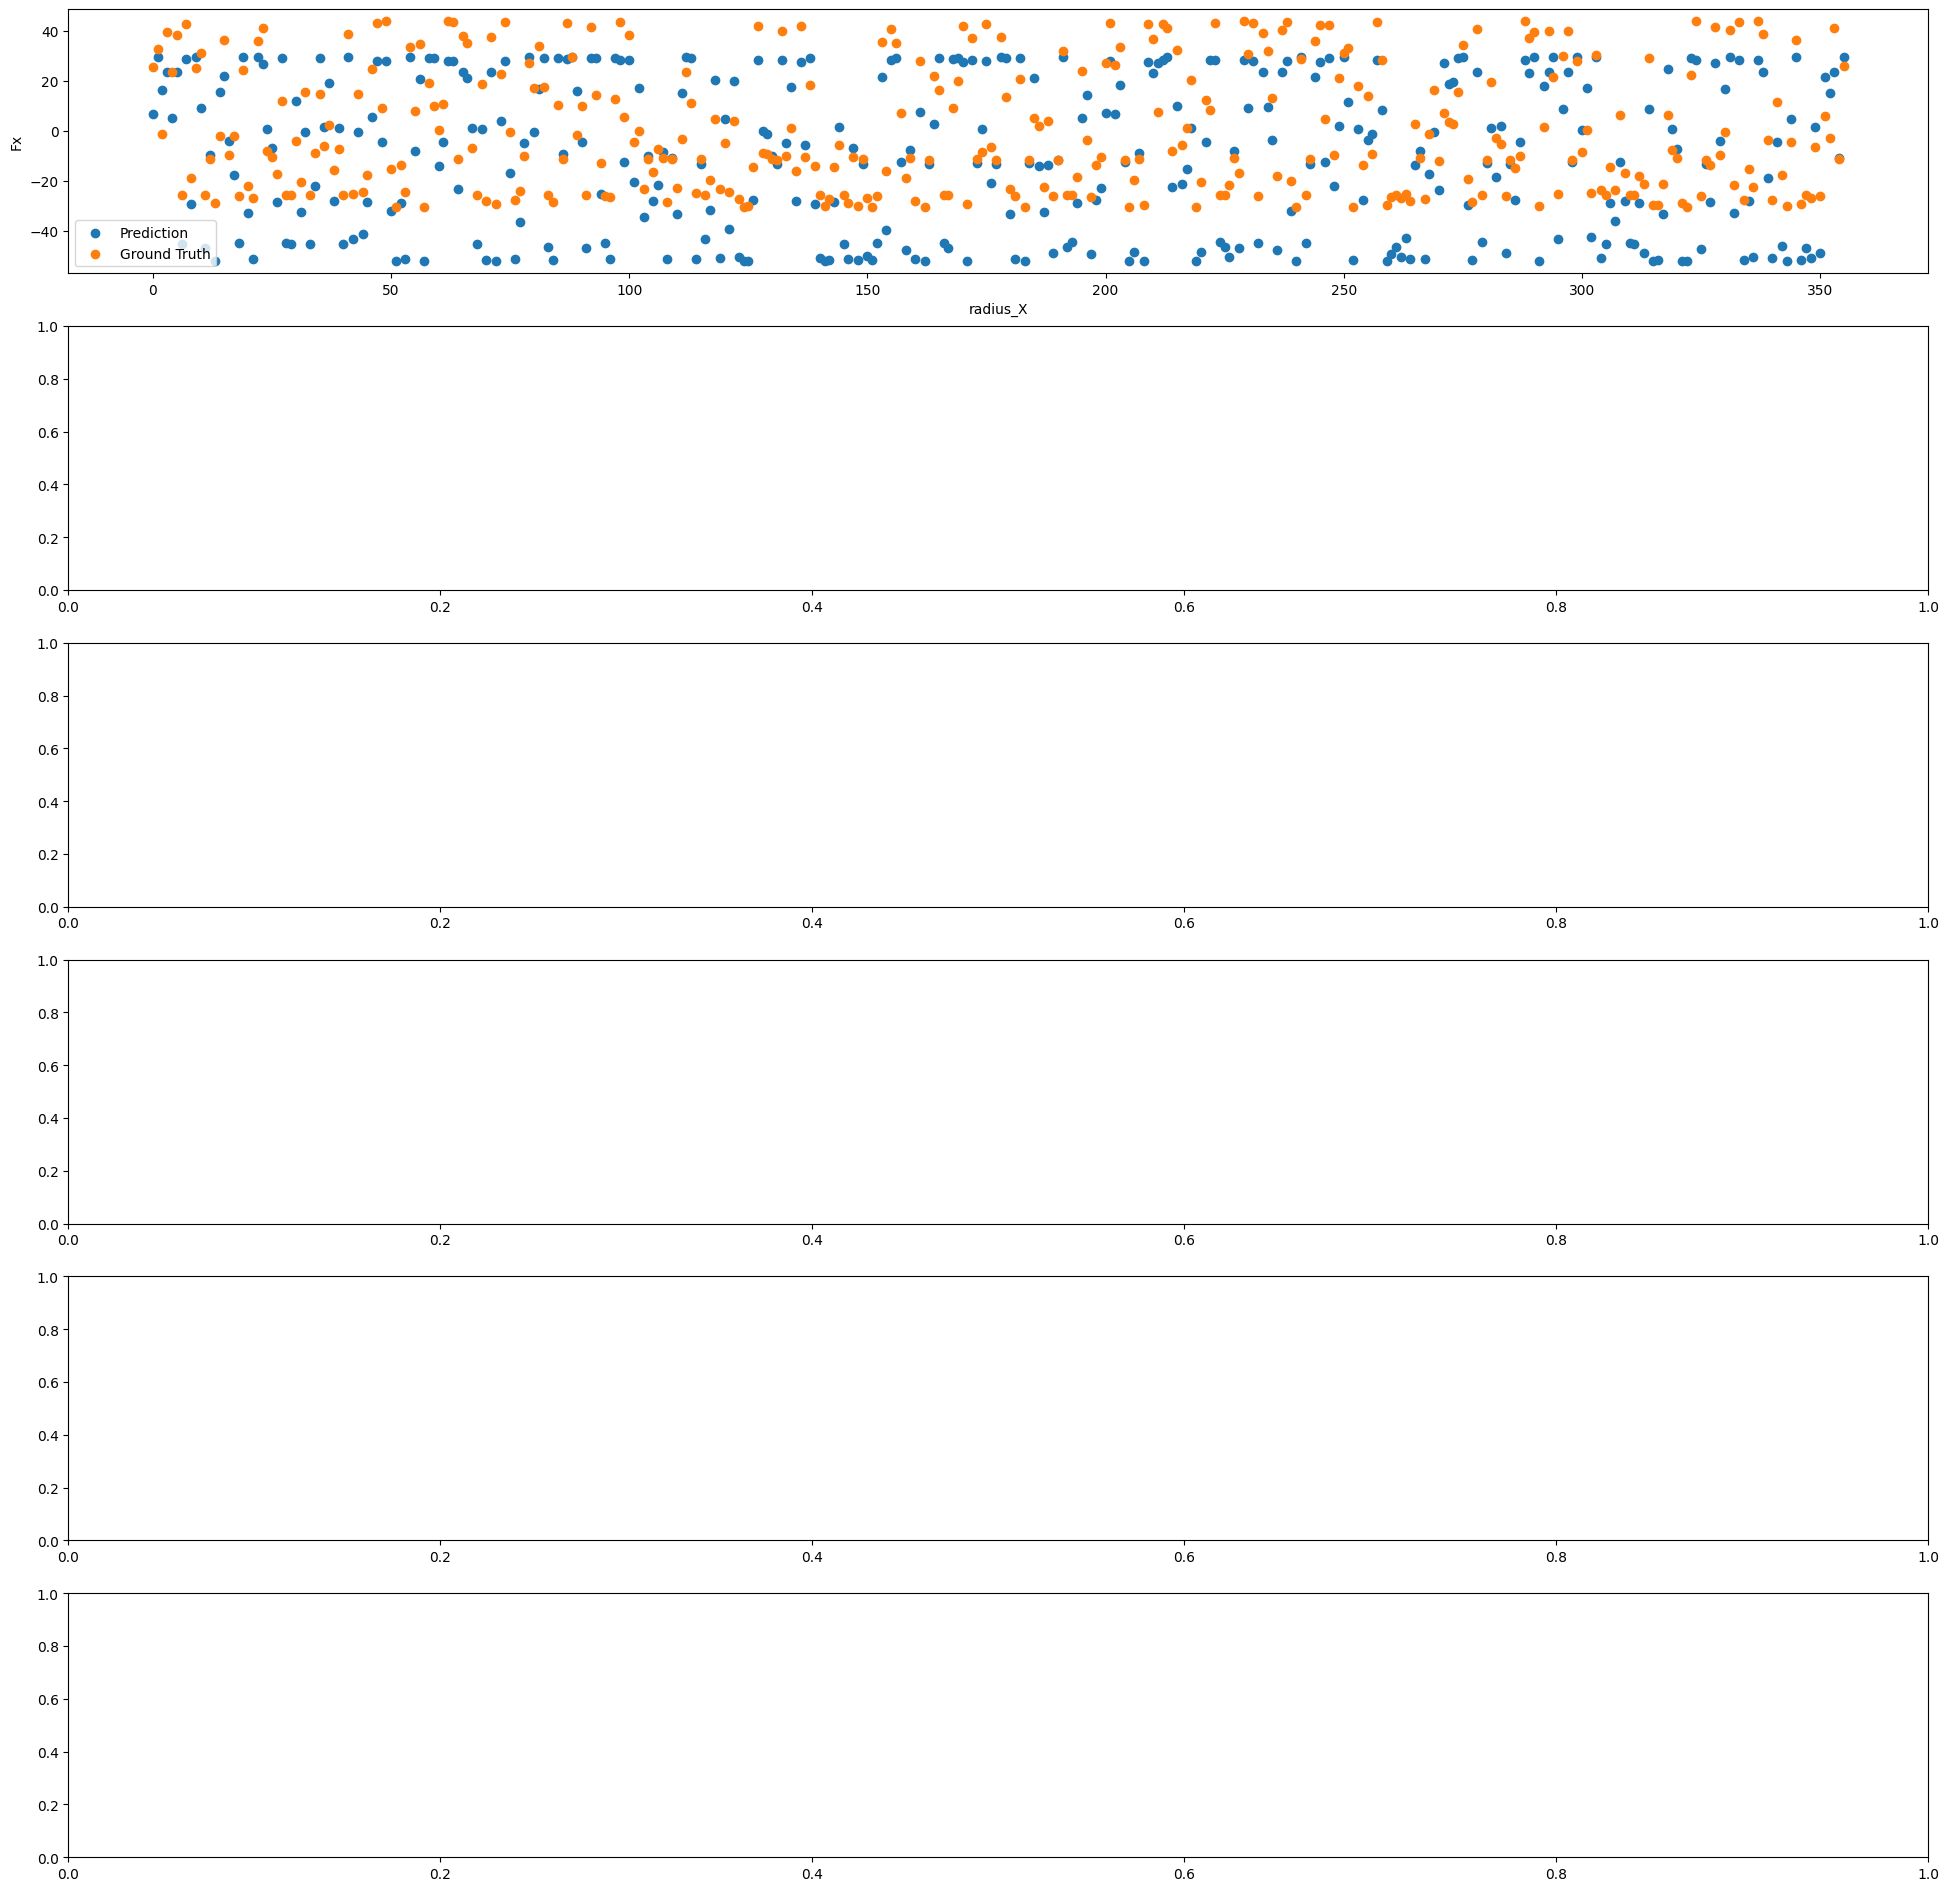

In [86]:
# getting MDPE based on test data set

# Initialize y_pred as a dictionary with keys for each output column
y_pred = {output_col: [] for output_col in output_columns}

mdpe_scores_outputs = {}
plot_data = []
i = 0
for output_col in output_columns:
    y_pred[output_col] = best_model.predict(X_test)[:, i]
    print(y_pred[output_col].shape)
    mdpe_scores = calculate_mdpe_by_participant_cycle_ids(y_pred, y_test, X_test, output_col)
    print(len(mdpe_scores))
    mdpe_scores_outputs[output_col] = mdpe_scores
    median = np.median(mdpe_scores)
    average = np.mean(mdpe_scores)
    print("Output Column:", output_col)
    print("MdPE:", median)
    print("MdPE average:", average)
    # Add data for plotting
    for score in mdpe_scores:
        plot_data.append({'Output': output_col, 'MDPE': score})
    i += 1


# Create a box-and-whisker plot with stripplot
plt.figure(figsize=(10, 6))
box_plot = sns.boxplot(x='Output', y='MDPE', data=pd.DataFrame(plot_data))
strip_plot = sns.stripplot(x='Output', y='MDPE', data=pd.DataFrame(plot_data), jitter=True, color=".25", marker='o',
                            size=2)  # Add individual data points with smaller dots
plt.title('Box-and-Whisker Plot of MDPE Scores for Each Output Column')

# Customize legend for the strip plot
legend_labels = {'Individual Data Points': 'o'}
handles, _ = strip_plot.get_legend_handles_labels()
box_plot.legend(handles, legend_labels.values(), title='Legend', loc='upper right')

plt.show()

13_HIIT01


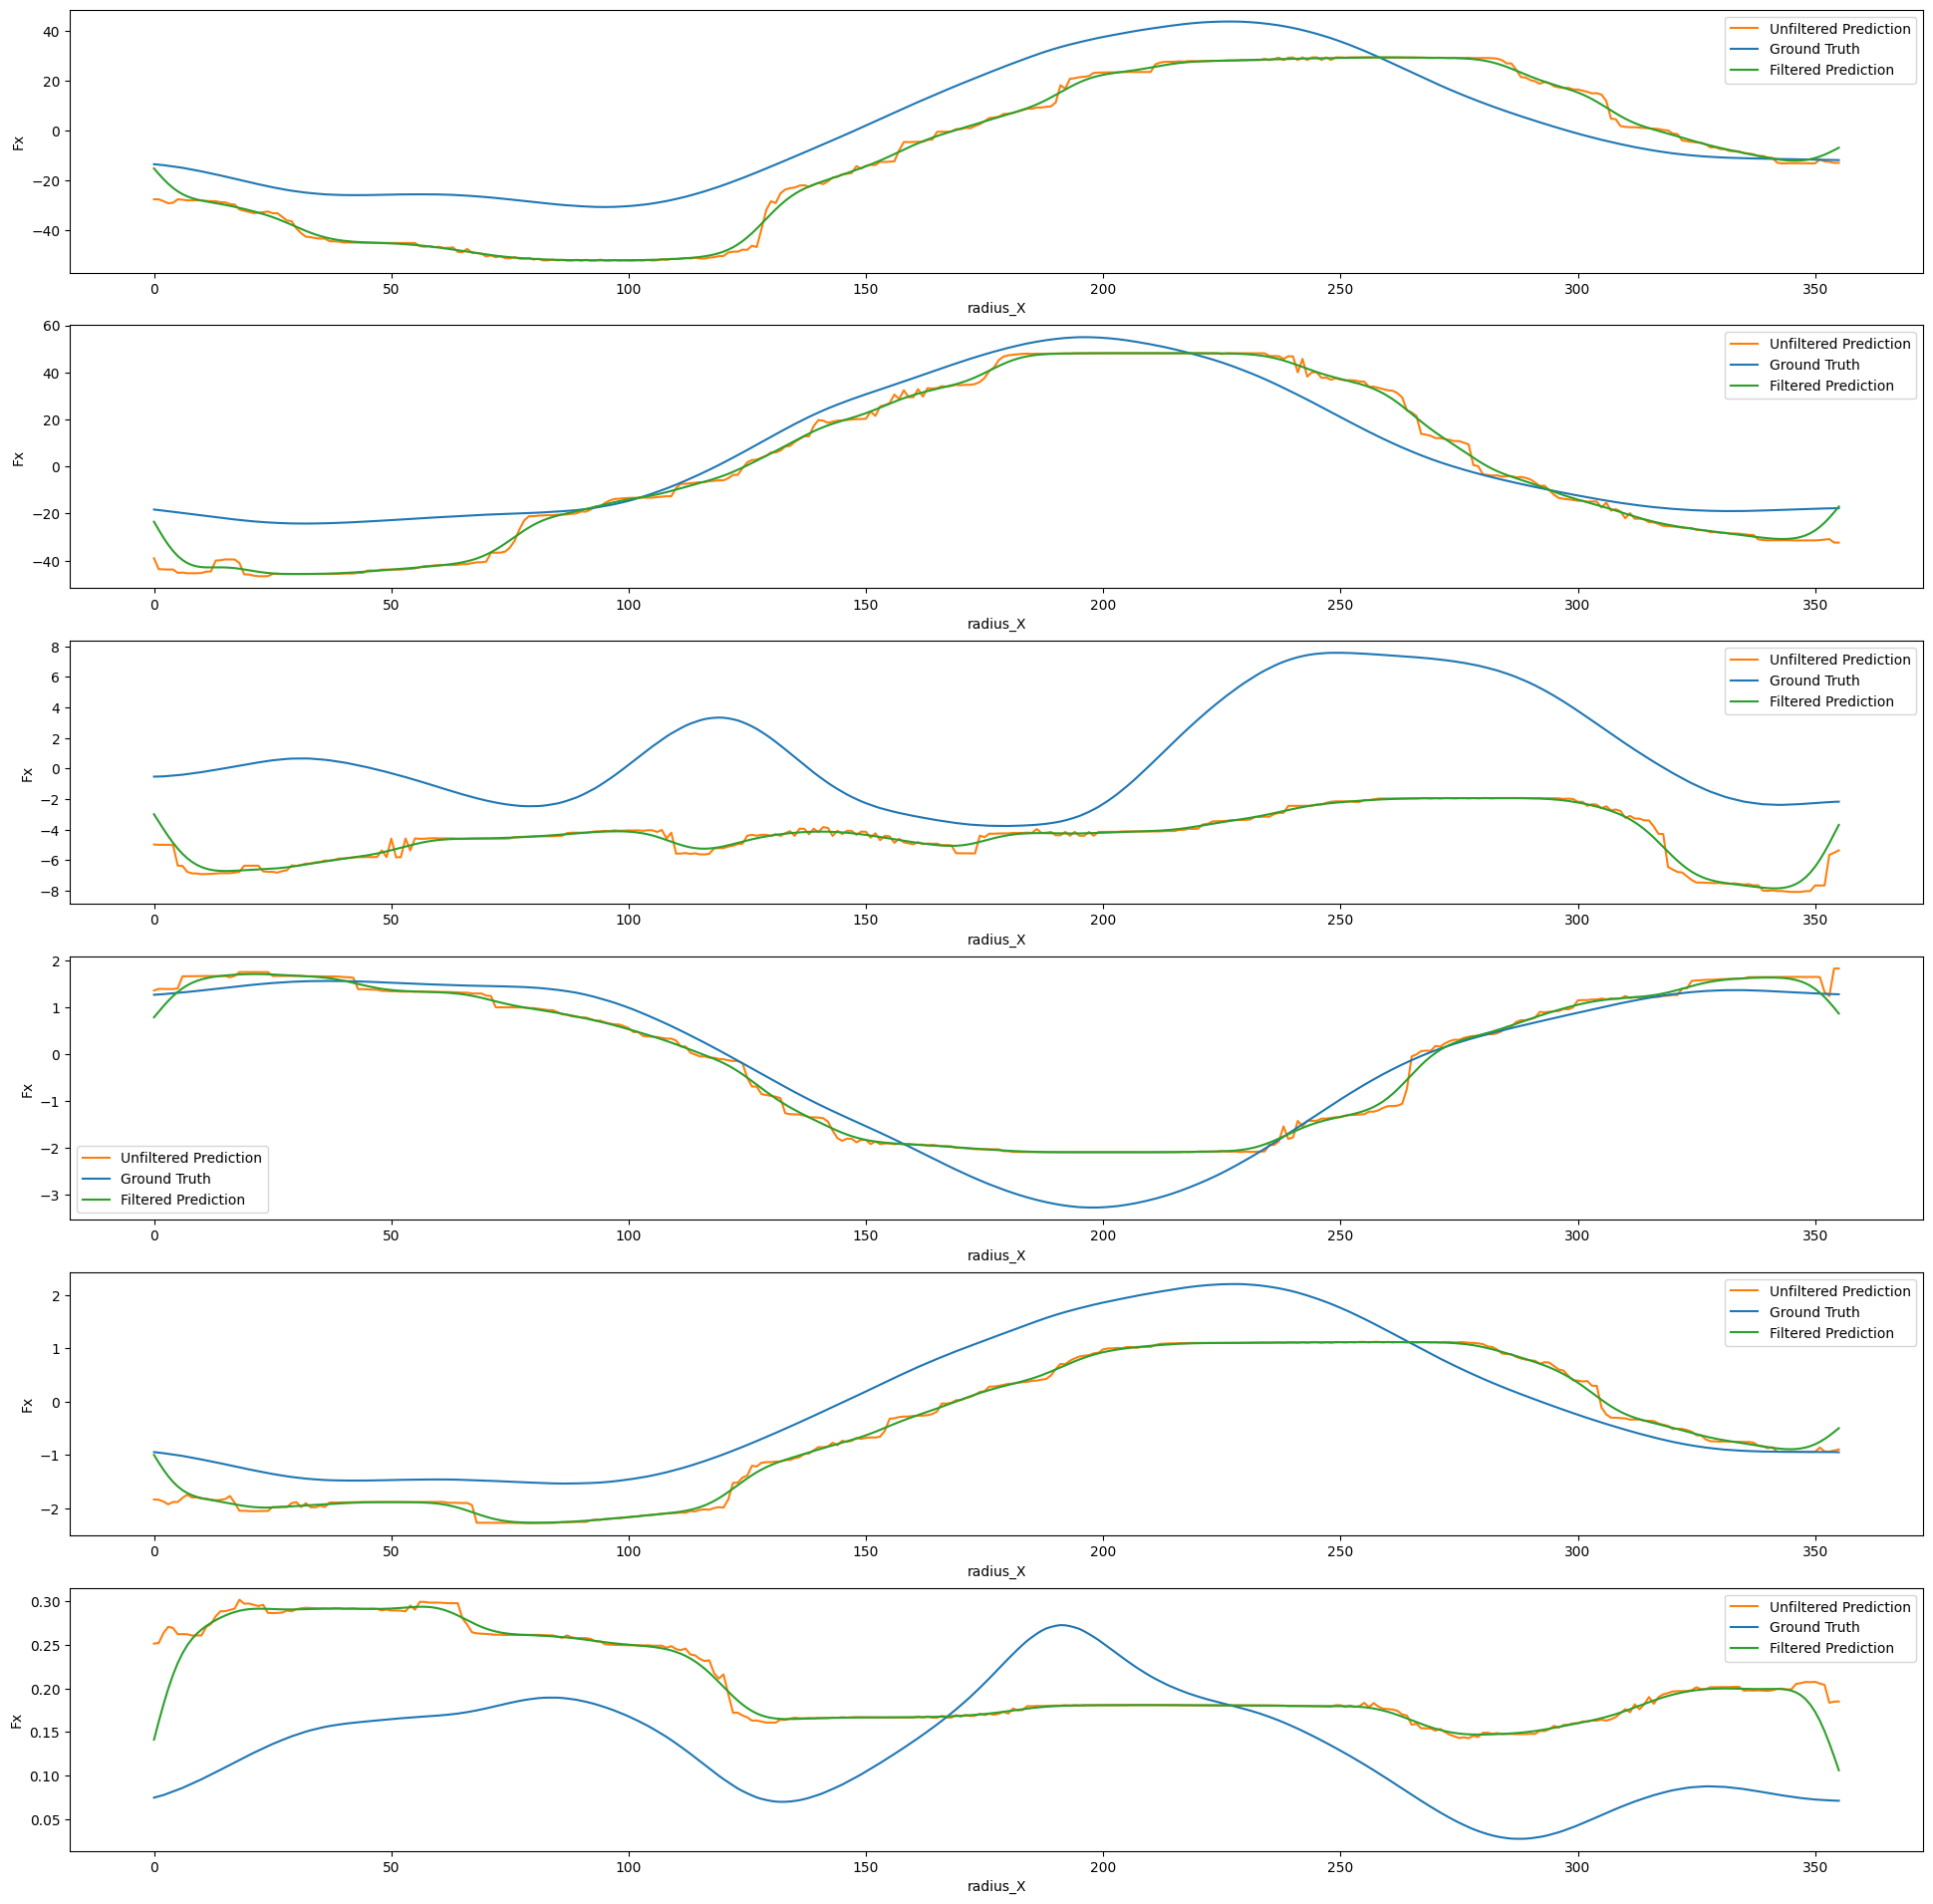

In [104]:
import numpy as np
from scipy.signal import butter, filtfilt, lfilter
import numpy as np
from scipy.ndimage import gaussian_filter1d
# Get the first prediction and ground truth

# Get the first unique key in Participant_Cycle_ID
first_key = X_test['Participant_Cycle_ID'].unique()[0]
print(first_key)

# Create the masked variables
X_test_masked = X_test[X_test['Participant_Cycle_ID'] == first_key]
X_test_masked = X_test_masked.sort_values('Normalized_Cycle_Position')
y_test_masked = y_test.loc[X_test_masked.index]
y_pred_first = best_model.predict(X_test_masked)
y_true_first = y_test_masked.to_numpy()
# FILEPATH: /c:/Users/griff/VS Code/Field-Based-Wheelchair-Biomechanics/Force Prediction/GBM.ipynb
window_size = 5
sigma = 5  # adjust the sigma value for desired smoothing effect
y_pred_smoothed = np.zeros_like(y_pred_first)

for i in range(y_pred_first.shape[1]):
    y_pred_smoothed[:, i] = gaussian_filter1d(y_pred_first[:, i], sigma=sigma, mode='constant')
    
# Create subplots for each feature
fig, axs = plt.subplots(6, 1, figsize=(24, 24))

# Create x values from 0 to 356
x_values = list(range(356))

# Plot the unfiltered predictions and ground truth for each feature
for i in range(y_pred_first.shape[1]):
    axs[i].plot(x_values, y_pred_first[:, i], color='tab:orange', label='Unfiltered Prediction')
    axs[i].plot(x_values, y_true_first[:, i], color='tab:blue', label='Ground Truth')
    axs[i].set_xlabel('radius_X')
    axs[i].set_ylabel('Fx')
    axs[i].legend()

# Plot the filtered predictions for each feature
for i in range(y_pred_smoothed.shape[1]):
    axs[i].plot(x_values, y_pred_smoothed[:, i], color='tab:green', label='Filtered Prediction')
    axs[i].legend()

# Show the plot
plt.show()
